In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import math
import dateutil.parser
from pandas.io.json import json_normalize
import json
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 

In [4]:
# import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [5]:
USAGE = '201906_Usage_Bicimad.json'

#  Limpieza de datos

In [6]:
usage_df = pd.read_json(USAGE, lines=True)

In [7]:
usage_df['unplug_hourTime'] = json_normalize(usage_df['unplug_hourTime'])

Transformamos en día y hora la fecha en que se coge cada bicicleta:

In [8]:
import datetime
usage_df['unplug_hourTime'] = pd.to_datetime(usage_df['unplug_hourTime']).dt.strftime("%m-%d-%Y, %H:%M:%S")

In [9]:
new = usage_df["unplug_hourTime"].str.split(", ", n = 1, expand = True) 

In [10]:
usage_df['unplug_date'] = new[0]
usage_df['unplug_hour'] = new[1]

In [11]:
usage_df.drop(columns =["unplug_hourTime"], inplace = True) 

In [13]:
def make_int(s):
    s = s.strip()
    if s.isdigit() and len(s) <= 8:
        return int(s)
    else: return 0

In [16]:
usage_df['zip_code'] = usage_df['zip_code'].apply(lambda x: make_int(x))

AttributeError: 'int' object has no attribute 'strip'

In [17]:
usage_df = usage_df.drop(['_id', 'user_day_code', 'idplug_base', 'idunplug_base', 'track'], axis = 1)

In [18]:
#hay usuarios con zip code == 0 (ruido, eliminamos también esta feature)
usage_df[usage_df['zip_code'] == 0].count()

user_type           221839
travel_time         221839
idunplug_station    221839
ageRange            221839
idplug_station      221839
zip_code            221839
unplug_date         221839
unplug_hour         221839
dtype: int64

In [19]:
usage_df['zip_code'].count()

450811

In [20]:
usage_df = usage_df.drop('zip_code', axis = 1)

In [21]:
usage_df.head()

,user_type,travel_time,idunplug_station,ageRange,idplug_station,unplug_date,unplug_hour
0,1,219,90,0,66,06-01-2019,00:00:00
1,1,359,71,4,136,06-01-2019,00:00:00
2,1,375,39,4,38,06-01-2019,00:00:00
3,1,264,66,5,90,06-01-2019,00:00:00
4,1,367,152,4,166,06-01-2019,00:00:00


In [22]:
usage_df.shape

(450811, 7)

# Análisis de datos

## Duración de los trayectos

Para analizar los tiempos de trayecto, pasamos de segundos a minutos la columna 'travel_time'.

- La media de tiempo de uso de de 17,24 minutos
- La desviación estandar es bastante alta: el tiempo mínimo es de 7 minutos, y el máximo de 11004 (7 días). Esto podría deberse a un fallo o pérdida.

In [23]:
usage_df['travel_time'] = usage_df['travel_time']/60
usage_df.head(5)

,user_type,travel_time,idunplug_station,ageRange,idplug_station,unplug_date,unplug_hour
0,1,3.650000,90,0,66,06-01-2019,00:00:00
1,1,5.983333,71,4,136,06-01-2019,00:00:00
2,1,6.250000,39,4,38,06-01-2019,00:00:00
3,1,4.400000,66,5,90,06-01-2019,00:00:00
4,1,6.116667,152,4,166,06-01-2019,00:00:00


In [24]:
usage_df['travel_time'].describe()

count    450811.000000
mean         17.240246
std          59.668311
min           0.000000
25%           7.833333
50%          11.716667
75%          17.533333
max       11004.283333
Name: travel_time, dtype: float64

In [25]:
import numpy as np 
import matplotlib as mpl 
import matplotlib.pyplot as plt 

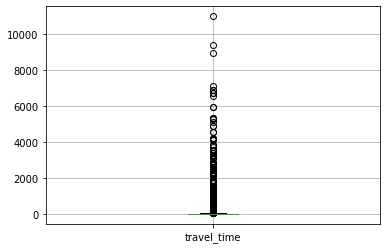

In [27]:
df_non_extreme_travel_times = usage_df.loc[usage_df['travel_time'] > 0]
df_non_extreme_travel_times.boxplot(column='travel_time')

Cuartiles: **Q1 = 7.833333, Q3 = 17.533333**

Rango intercuartílico (RI) = Q3 - Q1 = **9,7** min

Atípicos: (Sólo hay por el lado derecho)
    - LD = Q3 + 1.5RI = 32,083333
Atípicos extremos:
    - LD = Q3 + 3RI = 46,633333

In [53]:
#cuartiles 

usage_df['travel_time'].describe()

count    450811.000000
mean         17.240246
std          59.668311
min           0.000000
25%           7.833333
50%          11.716667
75%          17.533333
max       11004.283333
Name: travel_time, dtype: float64

In [60]:
usage_df[usage_df['travel_time'] > 33].count()

user_type           21435
travel_time         21435
idunplug_station    21435
ageRange            21435
idplug_station      21435
unplug_date         21435
unplug_hour         21435
dtype: int64

In [28]:
usage_df.loc[usage_df['travel_time'] > 6000].count()

user_type           9
travel_time         9
idunplug_station    9
ageRange            9
idplug_station      9
unplug_date         9
unplug_hour         9
dtype: int64

Observamos que hay alrededor de 21435 valores extremos, 9 de ellos de 4 días de duración (posiblemente debido a bicicletas perdidas o fallos en el sistema). Para que nuestro box-plot sea explicativo vamos a considerar sólo trayectos por debajo de una hora de duración:

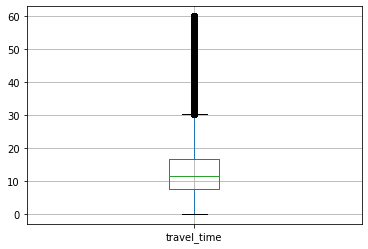

In [63]:
df_non_extreme_travel_times = usage_df.loc[usage_df['travel_time'] < 60]
df_non_extreme_travel_times.boxplot(column='travel_time')

## Uso de bicis por hora

In [29]:
time_list = usage_df['unplug_hour'].value_counts()
time_counts = pd.DataFrame(time_list)
time_counts.sort_index(inplace=True)
time_counts

,unplug_hour
00:00:00,13731
01:00:00,10012
02:00:00,7097
03:00:00,4343
04:00:00,3141
05:00:00,2321
06:00:00,3796
07:00:00,12704
08:00:00,27859
09:00:00,25339


Vemos que la hora punta son las 19:00, y la de menos ocupación las 05:00

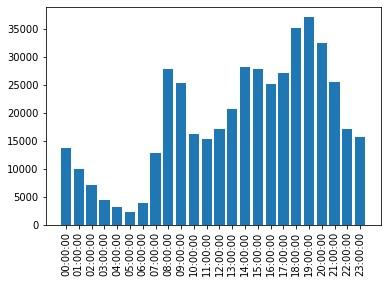

In [30]:
# Make a fake dataset:
time = time_counts['unplug_hour']
bars = time_counts.index
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, time)
 
# Create names on the x-axis
plt.xticks(y_pos, bars, rotation=90)

# Show graphic
plt.show()

In [31]:
usage_df['unplug_hour'].describe()

count       450811
unique          24
top       19:00:00
freq         37008
Name: unplug_hour, dtype: object

## Uso según el tipo de usuario

- 1: usuario anual
- 2: usuario ocasional
- 3: trabajador de la empresa

Vemos que el grupo que de más frecuencia de uso es el usuario anual. Sin embargo, este es el que realiza los trayectos de menor duración de media (15 minutos), frente a los usuarios ocasionales (40 minutos). Esto puede deberse a que el primer grupo se constituya por la gente que ba en bici al trabajo, hacer la compra, actividades rutinarias.

In [65]:
round(((pd.crosstab(index=usage_df["user_type"],columns="count").sort_values(by='count', ascending=False))/usage_df.user_type.count())*100, 2)

col_0,count
user_type,
1,92.89
3,5.84
2,1.27


In [33]:
file = pd.DataFrame(usage_df.groupby(['user_type'])['travel_time'].mean())
file.head()

,travel_time
user_type,
1,14.999532
2,41.094281
3,47.697213


#### Análisis de trayectos (estaciones de desenganche y enganche)

In [69]:
usage_df['idunplug_station'].unique().size
#180 valores únicos

180

In [77]:
misma_estacion = usage_df[usage_df['idunplug_station'] == usage_df['idplug_station']]
misma_estacion.count()

user_type           16336
travel_time         16336
idunplug_station    16336
ageRange            16336
idplug_station      16336
unplug_date         16336
unplug_hour         16336
dtype: int64

En las estaciones que se engancha y desenganchan bicis podemos ver que se repite mucho que se engancha y desengancha en la misma estacion. ¿por qué? 

buscando en usage_df los valores con mas viajes, podemos ver en el box_plot que la mayoria son de una duracion entre 0 - 50 min, los viajes de menos de un min podrian ser por algun tipo de equivocación y los demás podria ser de usuarios frecuentes quizas?  

In [37]:
new_df.sort_values(by=['size'], ascending=False)[:5]

,idunplug_station,idplug_station,size
21221,135,135,363
863,6,6,355
9873,64,64,331
1528,9,149,313
27766,175,175,298


In [38]:
stations_travel = usage_df[['idunplug_station','idplug_station', 'travel_time', 'user_type']].loc[(usage_df.idunplug_station == 135) & (usage_df.idplug_station == 135)]

In [39]:
stations_travel.loc[stations_travel.travel_time < 1].count()

idunplug_station    101
idplug_station      101
travel_time         101
user_type           101
dtype: int64

In [40]:
stations_travel.loc[stations_travel.travel_time < 1].mean()

idunplug_station    135.000000
idplug_station      135.000000
travel_time           0.213366
user_type             3.000000
dtype: float64

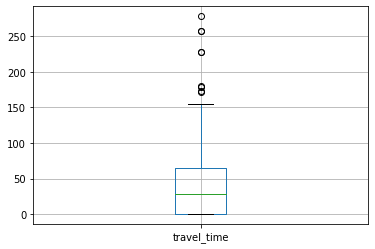

In [41]:
stations_travel.boxplot(column='travel_time')

Podemos ver que los viajes mas frecuentes son hechos por los abonados(algo obvio). Pero para los que son de menos de 5 min, la gran mayoria son de usuarios del tipo 3(empleados) por lo que podria ser por algun tipo de mantenimiento. 


De todo este analisis podriamos sacar que los viajes mas frecuentes podrian ser para realizar tareas diarias como ir al super o cuestiones parecidades ya que son usuarios que cogen las bicis y las dejan en la misma estación y la media no pasa de 50 min. 

In [42]:
stations_travel.loc[(stations_travel.travel_time > 10)].groupby(['user_type', 'travel_time']).count()

idunplug_station  idplug_station
user_type travel_time                                  
1         11.033333                   1               1
          11.116667                   1               1
          11.600000                   1               1
          11.916667                   1               1
          12.616667                   1               1
...                                 ...             ...
2         79.066667                   2               2
          90.666667                   1               1
          92.833333                   2               2
          107.950000                  1               1
3         178.983333                  1               1

[183 rows x 2 columns]

In [43]:
stations_travel.loc[(stations_travel.travel_time < 5)].groupby(['user_type', 'travel_time']).count()

idunplug_station  idplug_station
user_type travel_time                                  
3         0.033333                    7               7
          0.050000                    5               5
          0.066667                    3               3
          0.083333                   11              11
          0.100000                    2               2
          0.116667                   10              10
          0.133333                   14              14
          0.150000                    9               9
          0.166667                    3               3
          0.183333                    5               5
          0.200000                    2               2
          0.216667                    1               1
          0.233333                    2               2
          0.250000                    6               6
          0.266667                    1               1
          0.283333                    4               4
          0.300000                    2               2
          0.333333                    2               2
          0.383333                    1               1
          0.600000                    3               3
          0.650000                    2               2
          0.833333                    3               3
          0.850000                    1               1
          0.883333                    1               1
          0.983333                    1               1
          1.466667                    1               1
          1.850000                    2               2
          2.433333                    1               1
          3.800000                    1               1
          4.416667                    1               1

In [44]:
usage_df.corr()

,user_type,travel_time,idunplug_station,ageRange,idplug_station
user_type,1.000000,0.135024,0.059032,0.008933,0.049995
travel_time,0.135024,1.000000,0.012026,-0.020478,0.017147
idunplug_station,0.059032,0.012026,1.000000,-0.007310,0.104587
ageRange,0.008933,-0.020478,-0.007310,1.000000,-0.011310
idplug_station,0.049995,0.017147,0.104587,-0.011310,1.000000


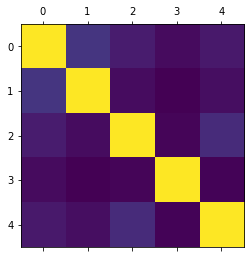

In [45]:
plt.matshow(usage_df.corr())